In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import numpy as np
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
from itertools import product
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
from statsmodels.tsa.arima.model import ARIMA
import itertools
from prophet import Prophet
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [ ]:
# Fill categorical missing values with 'Unknown'
df = pd.read_csv('cleaned_data_dropped.csv',low_memory=False)
categorical_cols = df.select_dtypes(include=['object']).columns
print(categorical_cols)

Index(['FACILITY NAME', 'ST', 'INDUSTRY SECTOR', 'CHEMICAL',
       'CLEAN AIR ACT CHEMICAL', 'CLASSIFICATION', 'METAL', 'METAL CATEGORY',
       'CARCINOGEN', 'PBT', 'PFAS', 'UNIT OF MEASURE'],
      dtype='object')


In [ ]:
# Aggregate by year (if not already aggregated)
time_series_data = df.groupby('YEAR')['TOTAL RELEASES'].sum().reset_index()

# Ensure the YEAR column is a datetime type
time_series_data['YEAR'] = pd.to_datetime(time_series_data['YEAR'], format='%Y')
# Step 1: Check stationarity and transform if needed
time_series_data['TOTAL RELEASES_diff'] = time_series_data['TOTAL RELEASES'].diff().dropna()

# ADF test for stationarity
adf_test = adfuller(time_series_data['TOTAL RELEASES_diff'].dropna())
print("ADF Statistic:", adf_test[0])
print("p-value:", adf_test[1])
outliers_detect = time_series_data.copy()
# Set YEAR as the index for time-series analysis
time_series_data.set_index('YEAR', inplace=True)

# Display the data
print(time_series_data.head())
print(time_series_data.columns)
print(outliers_detect.columns)

ADF Statistic: -4.69649054027993
p-value: 8.543953993527122e-05
            TOTAL RELEASES  TOTAL RELEASES_diff
YEAR                                           
2003-01-01    4.577736e+09                  NaN
2004-01-01    4.331598e+09        -2.461371e+08
2005-01-01    4.466363e+09         1.347647e+08
2006-01-01    4.456620e+09        -9.743215e+06
2007-01-01    4.249822e+09        -2.067978e+08
Index(['TOTAL RELEASES', 'TOTAL RELEASES_diff'], dtype='object')
Index(['YEAR', 'TOTAL RELEASES', 'TOTAL RELEASES_diff'], dtype='object')


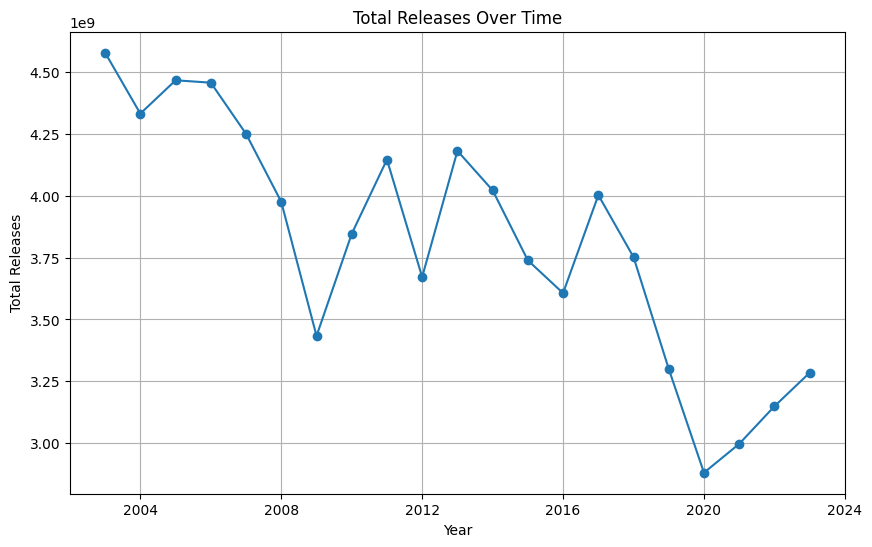

In [ ]:
# Plot the time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_data.index, time_series_data['TOTAL RELEASES'], marker='o')
plt.title('Total Releases Over Time')
plt.xlabel('Year')
plt.ylabel('Total Releases')
plt.grid()
plt.show()


In [246]:
# Calculate IQR
Q1 = time_series_data['TOTAL RELEASES'].quantile(0.25)
Q3 = time_series_data['TOTAL RELEASES'].quantile(0.75)
IQR = Q3 - Q1

# Identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR
outliers = time_series_data[(time_series_data['TOTAL RELEASES'] < lower_bound) | 
                            (time_series_data['TOTAL RELEASES'] > upper_bound)]
print("Q1", Q1)
print("Q3", Q3)
print("IQR", IQR)
print(time_series_data['TOTAL RELEASES'])
print("Outliers based on IQR:")
print(outliers)


Q1 3433271392.94323
Q3 4181039781.849695
IQR 747768388.906465
YEAR
2003-01-01    4.577736e+09
2004-01-01    4.331598e+09
2005-01-01    4.466363e+09
2006-01-01    4.456620e+09
2007-01-01    4.249822e+09
2008-01-01    3.975131e+09
2009-01-01    3.433271e+09
2010-01-01    3.846183e+09
2011-01-01    4.145959e+09
2012-01-01    3.671236e+09
2013-01-01    4.181040e+09
2014-01-01    4.021577e+09
2015-01-01    3.738664e+09
2016-01-01    3.606244e+09
2017-01-01    4.002350e+09
2018-01-01    3.751576e+09
2019-01-01    3.299707e+09
2020-01-01    2.880432e+09
2021-01-01    2.997275e+09
2022-01-01    3.149024e+09
2023-01-01    3.284579e+09
Name: TOTAL RELEASES, dtype: float64
Outliers based on IQR:
Empty DataFrame
Columns: [TOTAL RELEASES, TOTAL RELEASES_diff]
Index: []


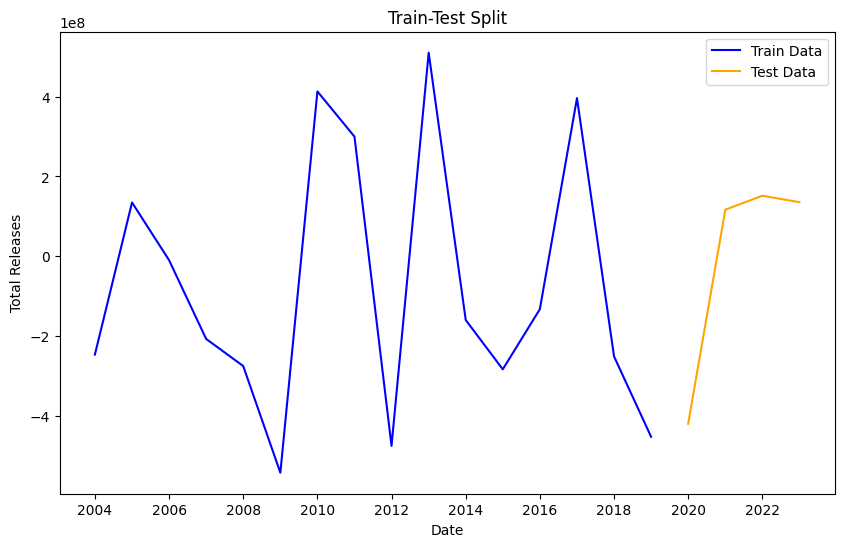

In [ ]:
# Define split ratio (e.g., 80% train, 20% test)
split_ratio = 0.8
split_index = int(len(time_series_data['TOTAL RELEASES_diff'].dropna()) * split_ratio)

# Split into train and test
train_data = time_series_data['TOTAL RELEASES_diff'].dropna()[:split_index]
test_data = time_series_data['TOTAL RELEASES_diff'].dropna()[split_index:]

# Define test_start and test_end
test_start = test_data.index[0]
test_end = test_data.index[-1]
# Extract actual values from the time series data for the test period
actual_values = time_series_data['TOTAL RELEASES_diff'].dropna()[test_start:test_end]

plt.figure(figsize=(10, 6))
plt.plot(train_data, label='Train Data', color='blue')
plt.plot(test_data, label='Test Data', color='orange')
plt.xlabel('Date')
plt.ylabel('Total Releases')
plt.title('Train-Test Split')
plt.legend()
plt.show()


In [ ]:

warnings.filterwarnings('ignore')

# Define parameter grid for SARIMA
p = d = q = range(0, 3)  # Non-seasonal params
P = D = Q = range(0, 2)  # Seasonal params
s = [12]  # Seasonal period (yearly data)

# Create all combinations
param_grid = list(product(p, d, q, P, D, Q, s))

# Track best parameters
best_rmse = float("inf")
best_params = None

# Grid search
for params in param_grid:
    try:
        sarima_model = SARIMAX(time_series_data['TOTAL RELEASES_diff'].dropna(),
                               order=(params[0], params[1], params[2]),
                               seasonal_order=(params[3], params[4], params[5], params[6]),
                               enforce_stationarity=False,
                               enforce_invertibility=False)
        results = sarima_model.fit(disp=False)
        # Predict and evaluate
        predictions = results.predict(start=test_start, end=test_end)
        rmse = mean_squared_error(actual_values, predictions, squared=False)
        if rmse < best_rmse:
            best_rmse = rmse
            best_params = params
    except Exception as e:
        continue

print(f'Best SARIMA Parameters: {best_params}')
print(f'Best RMSE: {best_rmse}')
print()
print()


Best SARIMA Parameters: (2, 1, 2, 1, 0, 0, 12)
Best RMSE: 5681.19506261412


In [ ]:
# Refit the model using the best parameters
best_model = SARIMAX(
    time_series_data['TOTAL RELEASES_diff'].dropna(), 
    order=(2, 1, 2),        # (p, d, q)
    seasonal_order=(1, 0, 0, 12),  # (P, D, Q, s)
    enforce_stationarity=False, 
    enforce_invertibility=False
)

best_model_fitted = best_model.fit(disp=False)
print(best_model_fitted.summary())

# Predict on the test set
predicted_values = best_model_fitted.predict(start=test_start, end=test_end)

# Calculate RMSE for the test set
from sklearn.metrics import mean_squared_error
import numpy as np

rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
print(f"Test RMSE: {rmse}")
print(actual_values)
print(predicted_values)



                                      SARIMAX Results                                      
Dep. Variable:                 TOTAL RELEASES_diff   No. Observations:                   20
Model:             SARIMAX(2, 1, 2)x(1, 0, [], 12)   Log Likelihood                -102.795
Date:                             Sun, 17 Nov 2024   AIC                            217.591
Time:                                     14:09:47   BIC                            215.247
Sample:                                 01-01-2004   HQIC                           211.301
                                      - 01-01-2023                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          1.1274   9.35e+04   1.21e-05      1.000   -1.83e+05    1.83e+05
ar.L2         -1.4253   2.3

2024-01-01   -2.545729e+08
2025-01-01   -1.436817e+09
2026-01-01   -9.127115e+08
2027-01-01    4.452818e+08
2028-01-01    1.529019e+09
Name: predicted_mean, dtype: float64
                 YEAR      FORECAST
2024-01-01 2024-12-31 -2.545729e+08
2025-01-01 2025-12-31 -1.436817e+09
2026-01-01 2026-12-31 -9.127115e+08
2027-01-01 2027-12-31  4.452818e+08
2028-01-01 2028-12-31  1.529019e+09


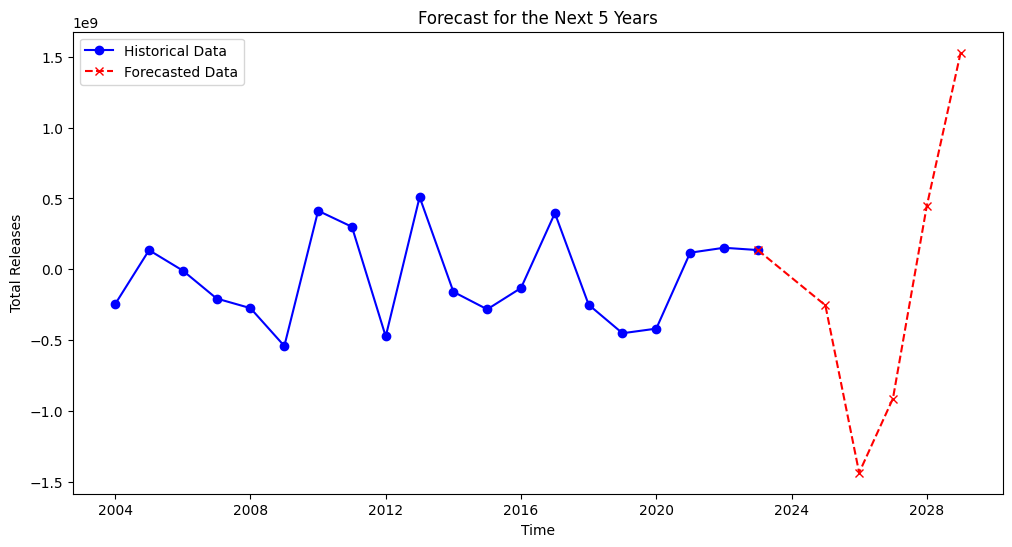

In [ ]:
# Forecast for the next 5 years (60 months)
forecast_steps = 5 * 12  # 5 years
forecast = best_model_fitted.forecast(steps=forecast_steps)

# Create a date range for the forecast
forecast_index = pd.date_range(start='2024-01-01', periods=forecast_steps, freq='MS')
forecast_series = pd.Series(forecast, index=forecast_index)
forecast_series = forecast_series.dropna()
# Print the forecasted values
print(forecast_series)
historical_df = time_series_data['TOTAL RELEASES_diff'].dropna().reset_index()
historical_df.columns = ['YEAR', 'ACTUAL']
# Display forecasted values
future_years = pd.date_range(start=time_series_data['TOTAL RELEASES_diff'].dropna().index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
forecast_df = pd.DataFrame({'YEAR': future_years, 'FORECAST': forecast_series})
print(forecast_df)
import matplotlib.pyplot as plt 

plt.figure(figsize=(12, 6))

# Plot the original time series data
# plt.plot(time_series_data, label='Actual', color='blue')

# Plot the forecast
# plt.plot(forecast_series, label='Forecast', color='orange')

# Plot historical data
plt.plot(historical_df['YEAR'], historical_df['ACTUAL'], label='Historical Data', marker='o', color='blue')

# Plot forecasted data
plt.plot([historical_df['YEAR'].iloc[-1]] + forecast_df['YEAR'].tolist(), 
         [historical_df['ACTUAL'].iloc[-1]] + forecast_df['FORECAST'].tolist(), 
         label='Forecasted Data', marker='x', linestyle='--', color='red')

plt.title('Forecast for the Next 5 Years')
plt.xlabel('Time')
plt.ylabel('Total Releases')
plt.legend()
plt.show()


In [ ]:
# Inverse the differencing to return to the original scale
last_value = time_series_data['TOTAL RELEASES'].iloc[-1]
forecast_original_scale = forecast_series.cumsum() + last_value  
forecast_original_scale

2024-01-01    3.030007e+09
2025-01-01    1.593189e+09
2026-01-01    6.804776e+08
2027-01-01    1.125759e+09
2028-01-01    2.654778e+09
Name: predicted_mean, dtype: float64

                 YEAR      FORECAST
2024-01-01 2024-12-31  3.030007e+09
2025-01-01 2025-12-31  1.593189e+09
2026-01-01 2026-12-31  6.804776e+08
2027-01-01 2027-12-31  1.125759e+09
2028-01-01 2028-12-31  2.654778e+09


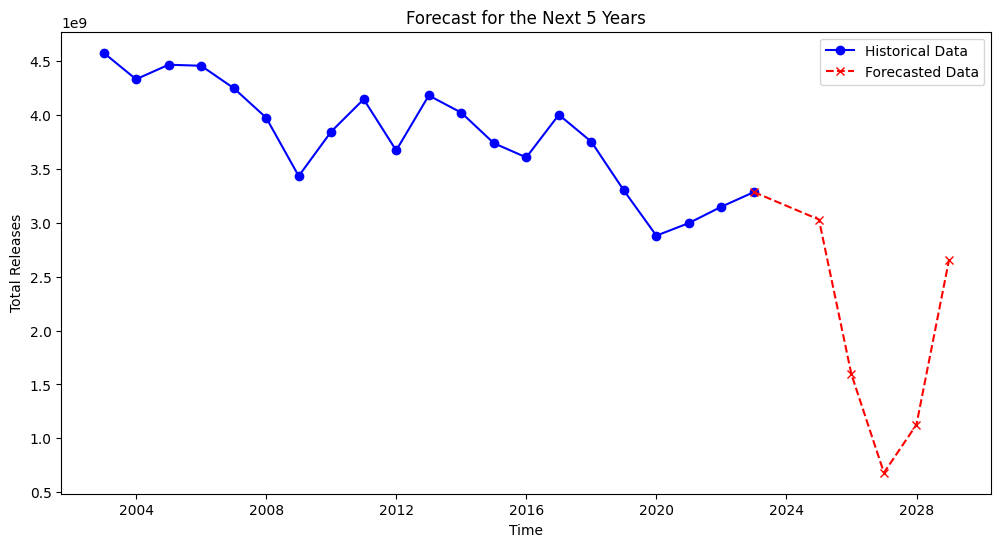

In [255]:
historical_df = time_series_data['TOTAL RELEASES'].dropna().reset_index()
historical_df.columns = ['YEAR', 'ACTUAL']
# Display forecasted values
future_years = pd.date_range(start=time_series_data['TOTAL RELEASES'].dropna().index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
forecast_df = pd.DataFrame({'YEAR': future_years, 'FORECAST': forecast_original_scale})
print(forecast_df)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))

# Plot the original time series data
# plt.plot(time_series_data, label='Actual', color='blue')

# Plot the forecast
# plt.plot(forecast_series, label='Forecast', color='orange')

# Plot historical data
plt.plot(historical_df['YEAR'], historical_df['ACTUAL'], label='Historical Data', marker='o', color='blue')

# Plot forecasted data
plt.plot([historical_df['YEAR'].iloc[-1]] + forecast_df['YEAR'].tolist(), 
         [historical_df['ACTUAL'].iloc[-1]] + forecast_df['FORECAST'].tolist(), 
         label='Forecasted Data', marker='x', linestyle='--', color='red')

plt.title('Forecast for the Next 5 Years')
plt.xlabel('Time')
plt.ylabel('Total Releases')
plt.legend()
plt.show()

In [ ]:

# Define the p, d, q parameter ranges
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_aic = float('inf')
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(time_series_data['TOTAL RELEASES_diff'].dropna(), order=param)
        model_fit = model.fit()
        if model_fit.aic < best_aic:
            best_aic = model_fit.aic
            best_pdq = param
    except:
        continue

print(f"Best ARIMA model order: {best_pdq} with AIC: {best_aic}")


Best ARIMA model order: (0, 2, 2) with AIC: 771.1946883227608


In [ ]:
# Define the parameter grid for ARIMA (p, d, q)
p = d = q = range(0, 3)
pdq = list(itertools.product(p, d, q))

best_rmse = float('inf')
best_pdq = None

for param in pdq:
    try:
        model = ARIMA(time_series_data['TOTAL RELEASES_diff'].dropna(), order=param)
        model_fit = model.fit()

        # Predict on the train set (or test set if available)
        predicted_values = model_fit.predict(start=test_start, end=test_end)

        # Calculate RMSE
        rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
        print(rmse)
        # Update best model if RMSE is better
        if rmse < best_rmse:
            best_rmse = rmse
            best_pdq = param
    except Exception as e:
        print(f"Error with parameters {param}: {e}")
        continue

print(f"Best ARIMA model order: {best_pdq} with RMSE: {best_rmse}")


247796994.280058
321240798.9046831
237455206.1452305
269242189.28323466
257890208.22550848
307223829.3296723
374823471.0149673
282799668.54990995
289658731.2063915
269806223.8102907
248419305.47190607
236306705.8336134
305162356.837544
275163573.4555147
256435232.20114404
445446882.4613159
319753477.9803543
289455769.9328625
293630095.80755556
215364603.85092983
227870865.89539918
378114849.39606017
296205891.91028994
235541929.1173578
502175545.4742989
389029521.8919802
313415216.1281023
Best ARIMA model order: (2, 0, 1) with RMSE: 215364603.85092983


In [269]:
# Fit the model with the best parameters
best_model = ARIMA(time_series_data['TOTAL RELEASES_diff'].dropna(), order=best_pdq)
best_model_fit = best_model.fit()

# Print the model summary
print(best_model_fit.summary())


                                SARIMAX Results                                
Dep. Variable:     TOTAL RELEASES_diff   No. Observations:                   20
Model:                  ARIMA(2, 0, 1)   Log Likelihood                -416.882
Date:                 Sun, 17 Nov 2024   AIC                            843.763
Time:                         15:36:13   BIC                            848.742
Sample:                     01-01-2004   HQIC                           844.735
                          - 01-01-2023                                         
Covariance Type:                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const      -6.466e+07   4.87e-09  -1.33e+16      0.000   -6.47e+07   -6.47e+07
ar.L1          0.4585      0.447      1.025      0.305      -0.418       1.335
ar.L2         -0.2169      0.424     -0.511 

2024-01-01   -1.112342e+08
2025-01-01   -1.294482e+08
2026-01-01   -8.425884e+07
2027-01-01   -5.958858e+07
2028-01-01   -5.808124e+07
Freq: YS-JAN, Name: predicted_mean, dtype: float64
                 YEAR      FORECAST
2024-01-01 2024-12-31 -1.112342e+08
2025-01-01 2025-12-31 -1.294482e+08
2026-01-01 2026-12-31 -8.425884e+07
2027-01-01 2027-12-31 -5.958858e+07
2028-01-01 2028-12-31 -5.808124e+07


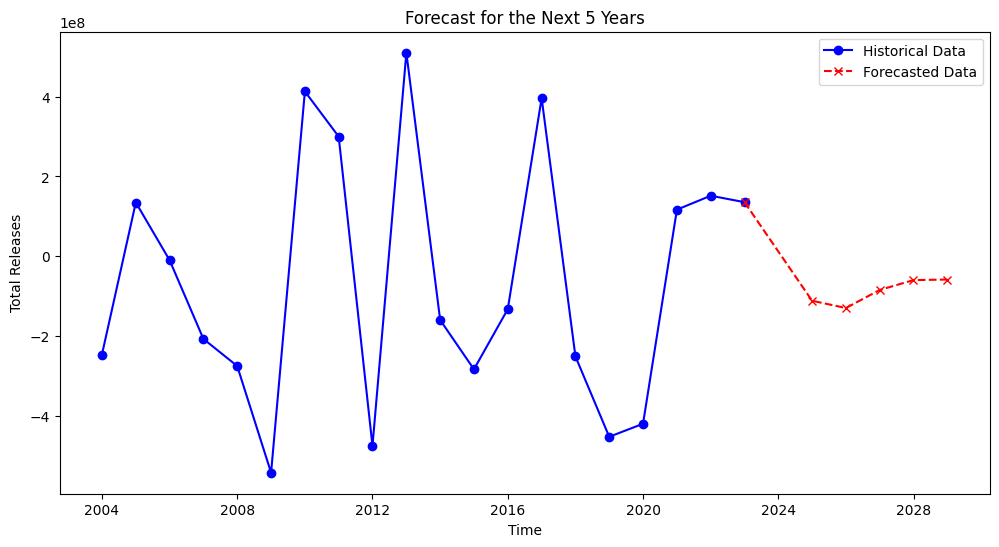

In [283]:
# Fit the ARIMA model with the best parameters (best_pdq)
model = ARIMA(time_series_data['TOTAL RELEASES_diff'].dropna(), order=best_pdq)  # Use the best (p, d, q) found during tuning
model_fit = model.fit()

forecast = model_fit.forecast(steps=5)
print(forecast)

historical_df = time_series_data['TOTAL RELEASES_diff'].dropna().reset_index()
historical_df.columns = ['YEAR', 'ACTUAL']
# Display forecasted values
future_years = pd.date_range(start=time_series_data['TOTAL RELEASES_diff'].dropna().index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
forecast_df = pd.DataFrame({'YEAR': future_years, 'FORECAST': forecast})
print(forecast_df)
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))


# Plot historical data
plt.plot(historical_df['YEAR'], historical_df['ACTUAL'], label='Historical Data', marker='o', color='blue')

# Plot forecasted data
plt.plot([historical_df['YEAR'].iloc[-1]] + forecast_df['YEAR'].tolist(), 
         [historical_df['ACTUAL'].iloc[-1]] + forecast_df['FORECAST'].tolist(), 
         label='Forecasted Data', marker='x', linestyle='--', color='red')

plt.title('Forecast for the Next 5 Years')
plt.xlabel('Time')
plt.ylabel('Total Releases')
plt.legend()
plt.show()


In [284]:
# Inverse the differencing to return to the original scale
last_value = time_series_data['TOTAL RELEASES'].iloc[-1]
forecast_original_scale = forecast.cumsum() + last_value
forecast_original_scale

2024-01-01    3.173345e+09
2025-01-01    3.043897e+09
2026-01-01    2.959638e+09
2027-01-01    2.900050e+09
2028-01-01    2.841968e+09
Freq: YS-JAN, Name: predicted_mean, dtype: float64

                 YEAR      FORECAST
2024-01-01 2024-12-31  3.173345e+09
2025-01-01 2025-12-31  3.043897e+09
2026-01-01 2026-12-31  2.959638e+09
2027-01-01 2027-12-31  2.900050e+09
2028-01-01 2028-12-31  2.841968e+09


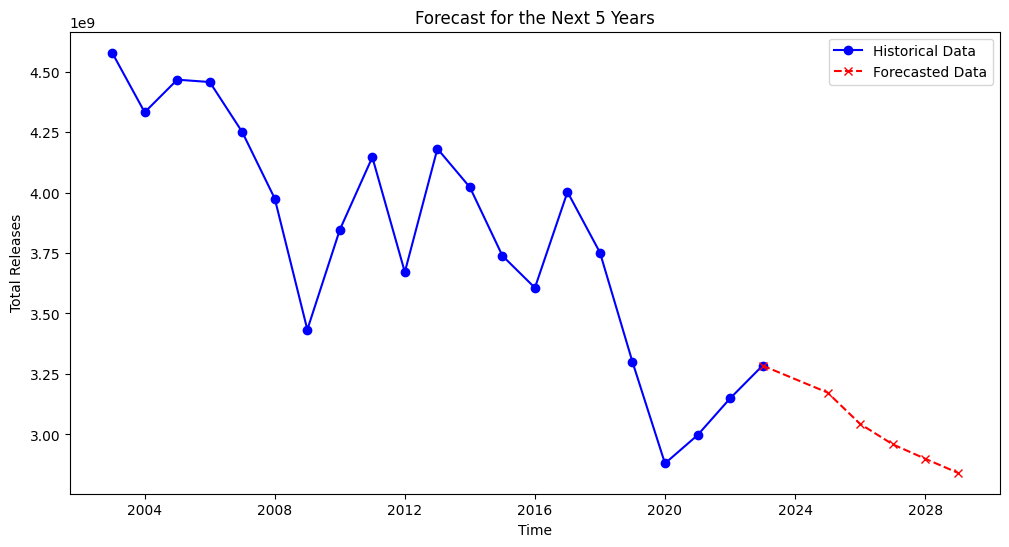

In [ ]:
historical_df = time_series_data['TOTAL RELEASES'].dropna().reset_index()
historical_df.columns = ['YEAR', 'ACTUAL']
# Display forecasted values
future_years = pd.date_range(start=time_series_data['TOTAL RELEASES'].dropna().index[-1] + pd.DateOffset(years=1), periods=5, freq='Y')
forecast_df = pd.DataFrame({'YEAR': future_years, 'FORECAST': forecast_original_scale})
print(forecast_df)
plt.figure(figsize=(12, 6))

# Plot the original time series data
# plt.plot(time_series_data, label='Actual', color='blue')

# Plot the forecast
# plt.plot(forecast_series, label='Forecast', color='orange')

# Plot historical data
plt.plot(historical_df['YEAR'], historical_df['ACTUAL'], label='Historical Data', marker='o', color='blue')

# Plot forecasted data
plt.plot([historical_df['YEAR'].iloc[-1]] + forecast_df['YEAR'].tolist(), 
         [historical_df['ACTUAL'].iloc[-1]] + forecast_df['FORECAST'].tolist(), 
         label='Forecasted Data', marker='x', linestyle='--', color='red')

plt.title('Forecast for the Next 5 Years')
plt.xlabel('Time')
plt.ylabel('Total Releases')
plt.legend()
plt.show()

In [ ]:
# Rename columns for Prophet
prophet_data = outliers_detect.rename(columns={'YEAR': 'ds', 'TOTAL RELEASES': 'y'})
# Fit the model
model = Prophet()
model.fit(prophet_data)

# Generate predictions
forecast = model.predict(prophet_data)

# Residuals
prophet_data['residuals'] = prophet_data['y'] - forecast['yhat']

# Highlight outliers
outliers = prophet_data[prophet_data['residuals'].abs() > 3 * prophet_data['residuals'].std()]
print("Outliers detected by Prophet:")
print(outliers)
 

17:34:07 - cmdstanpy - INFO - Chain [1] start processing
17:34:07 - cmdstanpy - INFO - Chain [1] done processing


Outliers detected by Prophet:
Empty DataFrame
Columns: [ds, y, residuals]
Index: []


In [ ]:
# Hyperparameter tuning for Prophet
best_rmse_prophet = float('inf')
best_prophet_params = None

# Hyperparameters for Prophet
changepoint_scales = [0.01, 0.1, 0.5]
seasonality_modes = ['additive', 'multiplicative']

# Assuming you have your time_series_data with 'TOTAL RELEASES'
# and you are working with the original time series (not differenced)
df_prophet = time_series_data[['TOTAL RELEASES_diff']].reset_index()
df_prophet.columns = ['ds', 'y']
# print(df_prophet[:-5])

for changepoint in changepoint_scales:
    for seasonality in seasonality_modes:
        try:
            # Create and fit the Prophet model
            model = Prophet(yearly_seasonality=True,changepoint_prior_scale=changepoint, seasonality_mode=seasonality)
            model.fit(df_prophet[:-5])

            # Forecast for the next 5 years (60 months)
            future = model.make_future_dataframe(periods=6, freq='Y',include_history=False)  # Forecasting for the next 5 years
            forecast = model.predict(future)
            # print(forecast_values)
            # Forecasted values
            forecast_values = forecast['yhat'][1:].values  # For the next 60 months
            print(forecast_values)

            # Compare with actual values (if available, for RMSE calculation)
            # You would compare these forecasted values with your test set if available
            # If no actual future values exist, this step can be skipped
            # Example assuming actual values for comparison (otherwise, remove this part):
            actual_values = time_series_data['TOTAL RELEASES_diff'][-5:]  # Adjust this as needed
            # print("--------------",(actual_values, forecast_values))
            rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))
            # print("--------------")

            # Update best RMSE and parameters
            if rmse < best_rmse_prophet:
                best_rmse_prophet = rmse
                best_prophet_params = (changepoint, seasonality)

        except Exception as e:
            print(f"Error with Prophet params (changepoint={changepoint}, seasonality={seasonality}): {e}")
            continue

print(f"Best Prophet model with RMSE: {best_rmse_prophet} and parameters: {best_prophet_params}")


16:20:21 - cmdstanpy - INFO - Chain [1] start processing
16:20:21 - cmdstanpy - INFO - Chain [1] done processing
16:20:21 - cmdstanpy - INFO - Chain [1] start processing


[-7.11818901e+08 -3.32744534e+08 -4.54034084e+08 -5.74927882e+08
 -6.95273686e+08]


16:20:22 - cmdstanpy - INFO - Chain [1] done processing
16:20:22 - cmdstanpy - INFO - Chain [1] start processing
16:20:23 - cmdstanpy - INFO - Chain [1] done processing


[-1.12559256e+09 -5.78454610e+08 -8.01208857e+08 -1.03678693e+09
 -1.28487120e+09]


16:20:23 - cmdstanpy - INFO - Chain [1] start processing


[-7.11681696e+08 -3.32535274e+08 -4.53840564e+08 -5.74750185e+08
 -6.95111868e+08]


16:20:23 - cmdstanpy - INFO - Chain [1] done processing
16:20:23 - cmdstanpy - INFO - Chain [1] start processing


[-1.17993925e+09 -6.03717990e+08 -8.38799045e+08 -1.08796088e+09
 -1.35089114e+09]


16:20:23 - cmdstanpy - INFO - Chain [1] done processing
16:20:23 - cmdstanpy - INFO - Chain [1] start processing


[-7.11377489e+08 -3.32057625e+08 -4.53401250e+08 -5.74349409e+08
 -6.94749765e+08]


16:20:24 - cmdstanpy - INFO - Chain [1] done processing


[-1.18081124e+09 -6.03773181e+08 -8.38935929e+08 -1.08819956e+09
 -1.35125745e+09]
Best Prophet model with RMSE: 568639752.1339357 and parameters: (0.5, 'additive')


16:20:35 - cmdstanpy - INFO - Chain [1] start processing
16:20:35 - cmdstanpy - INFO - Chain [1] done processing


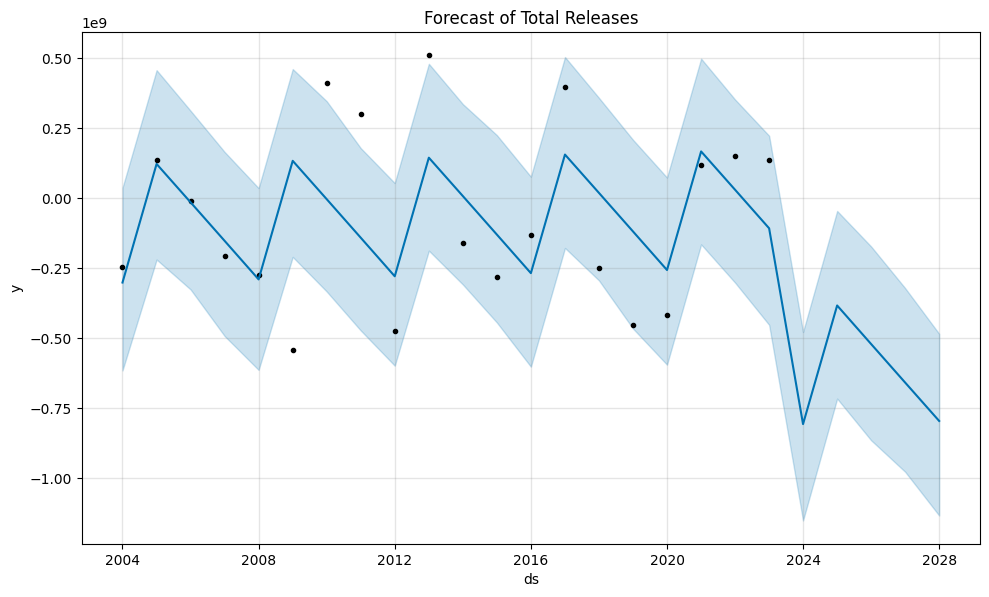

,ds,yhat,yhat_lower,yhat_upper
20,2023-12-31,-8.073671e+08,-1.151684e+09,-4.783018e+08
21,2024-12-31,-3.836090e+08,-7.162339e+08,-4.584421e+07
22,2025-12-31,-5.214391e+08,-8.652898e+08,-1.728581e+08
23,2026-12-31,-6.590194e+08,-9.777567e+08,-3.215333e+08
24,2027-12-31,-7.961788e+08,-1.134000e+09,-4.846860e+08


In [ ]:
time_series_prophet_data = time_series_data['TOTAL RELEASES_diff'].dropna().copy()
# Prepare data for Prophet
prophet_data = time_series_prophet_data.reset_index()
prophet_data.columns = ['ds', 'y']  # Prophet requires 'ds' for date and 'y' for the target

# Initialize and fit the Prophet model
model = Prophet(changepoint_prior_scale=0.5, seasonality_mode='additive',yearly_seasonality=True)
model.fit(prophet_data)

# Create a DataFrame for future years
future = model.make_future_dataframe(periods=5, freq='Y')  # Forecasting for the next 5 years
forecast = model.predict(future)

# Plot the forecast
model.plot(forecast)
plt.title('Forecast of Total Releases')
plt.show()

# Display forecasted values
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(5)


In [ ]:
# Assuming 'time_series_data' has 'TOTAL RELEASES' column with yearly data
df_hw = time_series_data[['TOTAL RELEASES']][:-5]
trend_options = ['add', 'mul']
# Try fitting with no seasonality and additive seasonality
best_rmse_hw = float('inf')
best_hw_params = None

for trend in trend_options:
    for seasonal in [None, 'mul','add']:  # 'None' means no seasonality, 'add' means additive seasonality
        try:
            # Fit the Holt-Winters Exponential Smoothing model
            if seasonal:
                model = ExponentialSmoothing(df_hw, trend=trend, seasonal=seasonal,seasonal_periods=1)  # Yearly data, seasonal periods=1
            else:
                model = ExponentialSmoothing(df_hw, trend=trend, seasonal=None)  # No seasonality
            
            model_fit = model.fit()

            # Forecast for the next 5 years (5 values)
            forecast_steps = 5  # Forecasting 5 years ahead
            forecast_values = model_fit.forecast(forecast_steps)
            # print(forecast_values)
            # If actual future values are available, calculate RMSE
            # Assuming actual values exist in the future for comparison
            actual_values = time_series_data['TOTAL RELEASES'].values[-5:]  # Adjust this if you have real data
            rmse = np.sqrt(mean_squared_error(actual_values, forecast_values))

            # Update best RMSE and parameters
            if rmse < best_rmse_hw:
                best_rmse_hw = rmse
                best_hw_params = (trend, seasonal)

        except Exception as e:
            print(f"Error with Exponential Smoothing params (seasonal={seasonal}): {e}")
            continue

print(f"Best Holt-Winters model with RMSE: {best_rmse_hw} and parameters: {best_hw_params}")


Error with Exponential Smoothing params (seasonal=mul): seasonal_periods must be larger than 1.
Error with Exponential Smoothing params (seasonal=add): seasonal_periods must be larger than 1.
Error with Exponential Smoothing params (seasonal=mul): seasonal_periods must be larger than 1.
Error with Exponential Smoothing params (seasonal=add): seasonal_periods must be larger than 1.
Best Holt-Winters model with RMSE: 410150433.53475714 and parameters: ('mul', None)


In [ ]:
# Fit Holt-Winters model (using additive trend and seasonality)
model = ExponentialSmoothing(time_series_data['TOTAL RELEASES'], trend='mul', seasonal=None).fit()

# Forecast the next 12 periods (e.g., months)
forecast = model.forecast(steps=5)
print(forecast)

2024-01-01    3.030442e+09
2025-01-01    2.967577e+09
2026-01-01    2.906015e+09
2027-01-01    2.845731e+09
2028-01-01    2.786697e+09
Freq: YS-JAN, dtype: float64


17:36:28 - cmdstanpy - INFO - Chain [1] start processing
17:36:28 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\psath\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.12_qbz5n2kfra8p0\LocalCache\local-packages\Python312\site-packages\prophet\forecaster.py:1854: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  dates = pd.date_range(


MAE: 364498384.12
RMSE: 395518670.50
MAPE: 11.60%


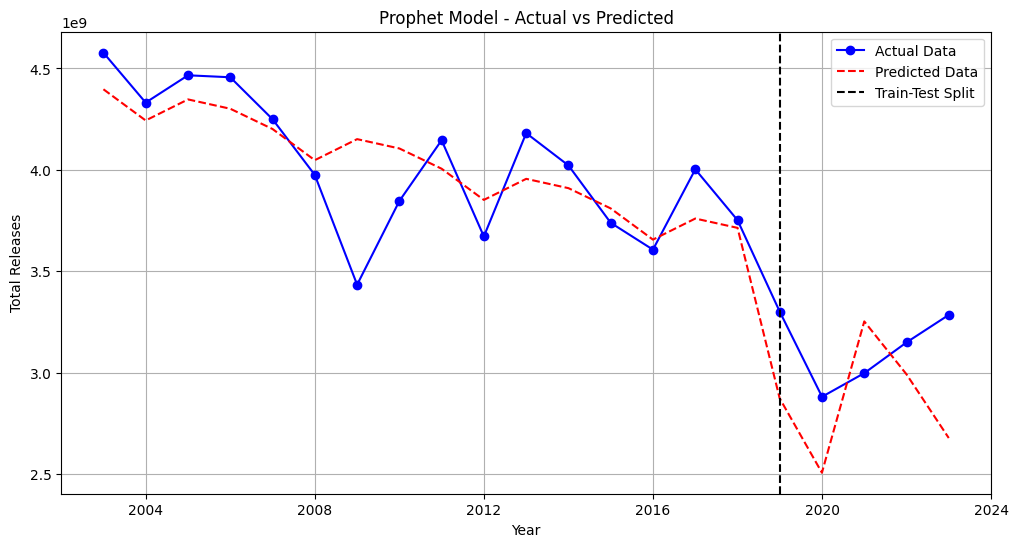

In [ ]:
# Prepare the data (ensure 'ds' column is for dates and 'y' is for target values)
data_time_series_prophet_data = time_series_prophet_data.reset_index().rename(columns={'YEAR': 'ds', 'TOTAL RELEASES': 'y'})

# Split the data into training and testing sets (80% train, 20% test)
train_size = int(len(data_time_series_prophet_data) * 0.8)
train_data = data_time_series_prophet_data.iloc[:train_size]
test_data = data_time_series_prophet_data.iloc[train_size:]

# Fit the Prophet model on the training set
model = Prophet()
model.fit(train_data)

# Make predictions on the test set
future = model.make_future_dataframe(periods=len(test_data), freq='Y')
forecast = model.predict(future)

# Extract the predictions corresponding to the test set
forecast_test = forecast.iloc[-len(test_data):]

# Calculate evaluation metrics
mae = mean_absolute_error(test_data['y'], forecast_test['yhat'])
rmse = np.sqrt(mean_squared_error(test_data['y'], forecast_test['yhat']))
mape = np.mean(np.abs((test_data['y'] - forecast_test['yhat']) / test_data['y'])) * 100

# Print the evaluation results
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"MAPE: {mape:.2f}%")

# Plot the results
import matplotlib.pyplot as plt
plt.figure(figsize=(12, 6))
plt.plot(data_time_series_prophet_data['ds'], data_time_series_prophet_data['y'], label='Actual Data', color='blue', marker='o')
plt.plot(forecast['ds'], forecast['yhat'], label='Predicted Data', color='red', linestyle='--')
plt.axvline(data_time_series_prophet_data['ds'].iloc[train_size], color='black', linestyle='--', label='Train-Test Split')
plt.title('Prophet Model - Actual vs Predicted')
plt.xlabel('Year')
plt.ylabel('Total Releases')
plt.legend()
plt.grid()
plt.show()


KeyError: 'ds'

<Figure size 1200x600 with 0 Axes>

In [ ]:
# Add historical data to the comparison DataFrame
historical_df = train.reset_index().rename(columns={'TOTAL RELEASES': 'Actual'})
comparison_df = pd.concat([historical_df, comparison_df]).sort_values(by='Year')


In [ ]:

for col in categorical_cols:
    df[col].fillna('Unknown', inplace=True)

# Fill numeric missing values with the column mean
numeric_cols = df.select_dtypes(include=[np.number]).columns
for col in numeric_cols:
    df[col].fillna(df[col].mean(), inplace=True)


C:\Users\psath\AppData\Local\Temp\ipykernel_7220\1270653409.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df[col].fillna('Unknown', inplace=True)
C:\Users\psath\AppData\Local\Temp\ipykernel_7220\1270653409.py:9: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when 

In [ ]:
df = pd.get_dummies(df, columns=categorical_cols, drop_first=True)
# df.to_csv('cleaned_data_for_models.csv', index=False)


In [ ]:
X = df.drop(columns=['TOTAL RELEASES'])
y = df['TOTAL RELEASES']


In [ ]:
print(df.columns)

Index(['YEAR', 'INDUSTRY SECTOR CODE', 'FUGITIVE AIR', 'STACK AIR', 'WATER',
       'UNDERGROUND', 'LANDFILLS', 'LAND TREATMENT', 'SURFACE IMPNDMNT',
       'OTHER DISPOSAL',
       ...
       'METAL CATEGORY_Metals with qualifiers', 'METAL CATEGORY_Non_Metal',
       'METAL CATEGORY_Unknown', 'CARCINOGEN_Unknown', 'CARCINOGEN_YES',
       'PBT_Unknown', 'PBT_YES', 'PFAS_Unknown', 'PFAS_YES',
       'UNIT OF MEASURE_Unknown'],
      dtype='object', length=720)


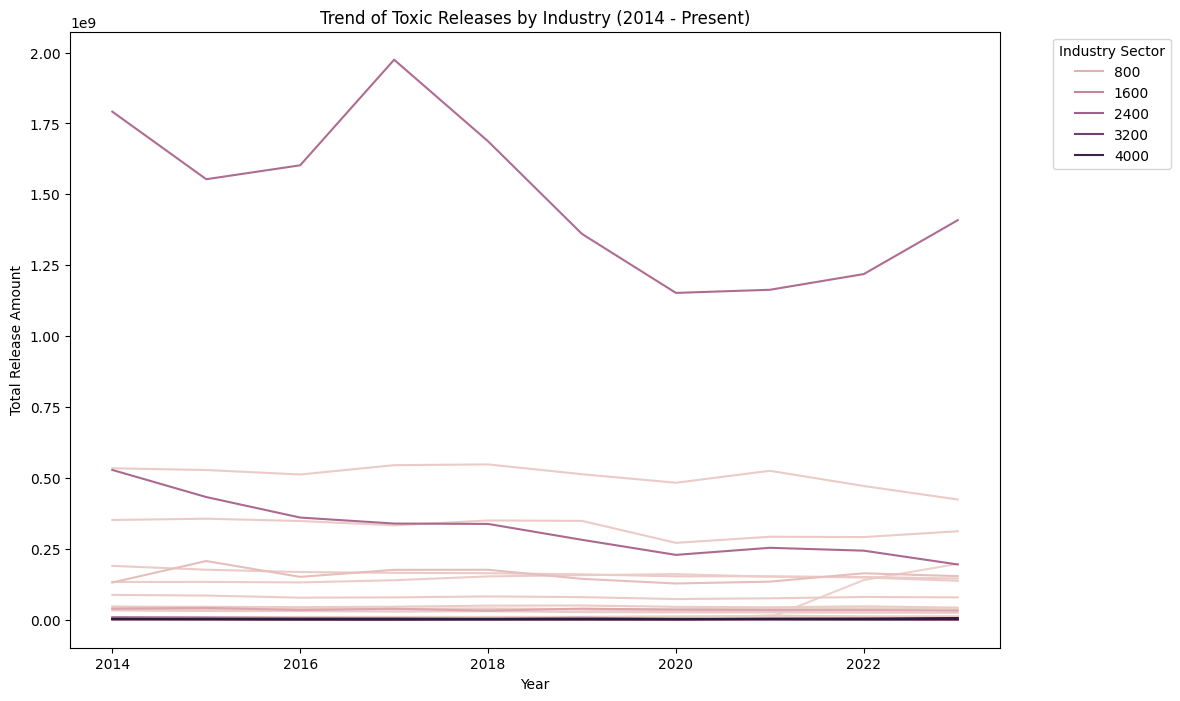

In [ ]:
industry_trends = df.groupby(['YEAR', 'INDUSTRY SECTOR CODE'])['TOTAL RELEASES'].sum().reset_index()

# Plot industry trends over time
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(12, 8))
sns.lineplot(data=industry_trends, x='YEAR', y='TOTAL RELEASES', hue='INDUSTRY SECTOR CODE')
plt.title('Trend of Toxic Releases by Industry (2014 - Present)')
plt.ylabel('Total Release Amount')
plt.xlabel('Year')
plt.legend(title='Industry Sector', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

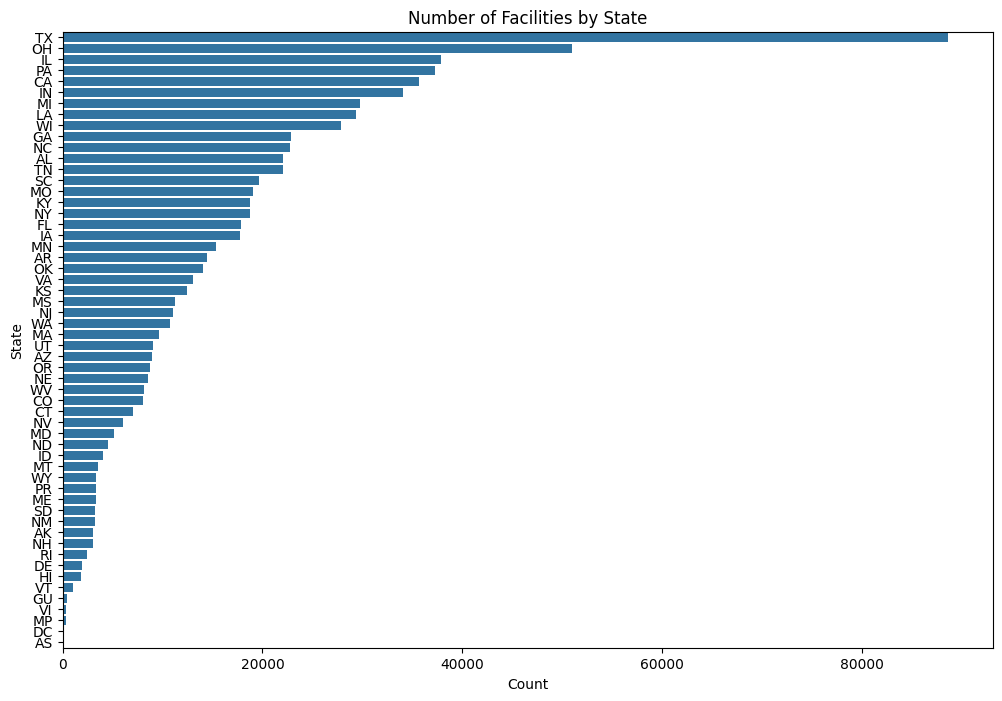

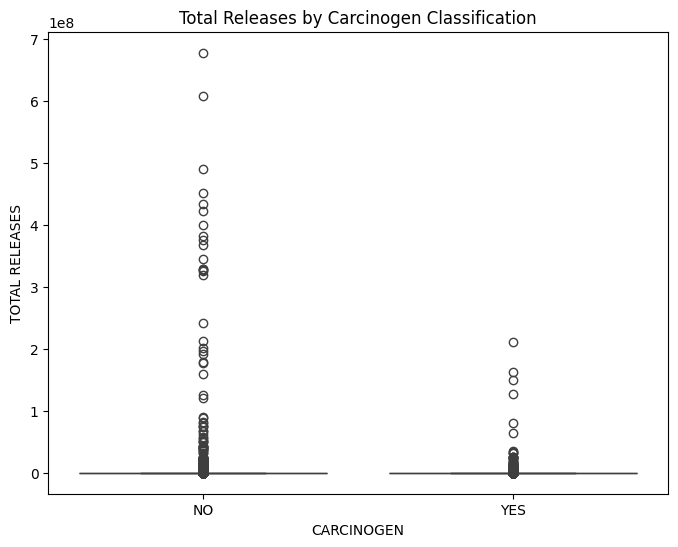

In [ ]:
# Plotting number of facilities by state
plt.figure(figsize=(12, 8))
sns.countplot(y='ST', data=data, order=data['ST'].value_counts().index)
plt.title("Number of Facilities by State")
plt.xlabel("Count")
plt.ylabel("State")
plt.show()

# Relationship between CARCINOGEN and TOTAL RELEASES
plt.figure(figsize=(8, 6))
sns.boxplot(data=data, x='CARCINOGEN', y='TOTAL RELEASES')
plt.title("Total Releases by Carcinogen Classification")
plt.show()

In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [ ]:
# scaler = StandardScaler()
# X_train = scaler.fit_transform(X_train)
# X_test = scaler.transform(X_test)


In [ ]:
# lr = LinearRegression()
# lr.fit(X_train, y_train)
# y_pred_lr = lr.predict(X_test)

# # Evaluate
# print("Linear Regression RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_lr)))
# print("Linear Regression R^2:", r2_score(y_test, y_pred_lr))


Linear Regression RMSE: 6651.617608052711
Linear Regression R^2: 0.9999899278684227


In [ ]:
# dt = DecisionTreeRegressor(random_state=42)
# dt.fit(X_train, y_train)
# y_pred_dt = dt.predict(X_test)


# # Evaluate
# print("Decision Tree RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_dt)))
# print("Decision Tree R^2:", r2_score(y_test, y_pred_dt))


Decision Tree RMSE: 174791.9096560993
Decision Tree R^2: 0.9930448020260622


In [ ]:
# rf = RandomForestRegressor(random_state=42)
# rf.fit(X_train, y_train)
# y_pred_rf = rf.predict(X_test)

# # Evaluate
# print("Random Forest RMSE:", np.sqrt(mean_squared_error(y_test, y_pred_rf)))
# print("Random Forest R^2:", r2_score(y_test, y_pred_rf))
